In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, cross_val_predict, KFold, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score, make_scorer
from sklearn.utils import all_estimators
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
import warnings

In [71]:
def evaluate_regressors(X, y, kfold, scorer, param_grids, all_regressors):
    results = []
    best_models = {}

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for name, RegressorClass in all_regressors:
        try:
            if not issubclass(RegressorClass, RegressorMixin):
                continue

            # Identifique colunas categóricas e numéricas
            categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
            numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

            # Crie o pré-processador
            preprocessor = ColumnTransformer(transformers=[
                ('num', StandardScaler(), numerical_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
            ])

            # Pipeline completo
            pipe = Pipeline([
                ('preprocessor', preprocessor),
                ('regressor', RegressorClass())
            ])

            param_grid = param_grids.get(name, {})
            grid = GridSearchCV(pipe, param_grid, scoring=scorer, cv=kfold, n_jobs=-1)
            grid.fit(X_train, y_train)

            y_pred = cross_val_predict(grid.best_estimator_, X_train, y_train, cv=kfold)

            neg_mse_scores = cross_val_score(grid.best_estimator_, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold)
            rmse_mean = np.sqrt(-neg_mse_scores.mean())
            rmse_std = neg_mse_scores.std() / (2 * np.sqrt(-neg_mse_scores.mean()))
            mae = mean_absolute_error(y_train, y_pred)
            r2 = r2_score(y_train, y_pred)

            results.append({
                'Regressor': name,
                'RMSE Mean': rmse_mean,
                'RMSE Std': rmse_std,
                'MAE': mae,
                'MSE': -neg_mse_scores.mean(),
                'R²': r2
            })

            best_models[name] = (grid.best_estimator_, rmse_mean)

        except Exception as e:
            print(f"Erro com {name}: {e}")

    return results, best_models, X_test, y_test

def rank_models(results, nome_target=""):
    results_df = pd.DataFrame(results)

    results_df['RMSE_rank'] = results_df['RMSE Mean'].rank(ascending=True)
    results_df['MAE_rank'] = results_df['MAE'].rank(ascending=True)
    results_df['R2_rank'] = results_df['R²'].rank(ascending=False)

    results_df['Avg_rank'] = results_df[['RMSE_rank', 'MAE_rank', 'R2_rank']].mean(axis=1)
    top4_df = results_df.sort_values(by='Avg_rank').head(4)

    print(f"\nTop 4 modelos para {nome_target} considerando todas as métricas:")
    print(top4_df[['Regressor', 'RMSE Mean', 'MAE', 'R²', 'Avg_rank']])

    return results_df, top4_df

def plot_best(results_df, best_models, X_test, y_test, nome_target=""):
    best_name = results_df.sort_values(by='Avg_rank').iloc[0]['Regressor']
    best_model = best_models[best_name][0]
    y_pred = best_model.predict(X_test)

    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:100].values, label='Real', marker='o')
    plt.plot(y_pred[:100], label='Previsto', marker='x')
    plt.title(f"Melhor modelo para {nome_target}: {best_name} - Previsão vs Real")
    plt.xlabel("Amostras")
    plt.ylabel("Carga térmica")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


data = pd.read_excel("ENB2012_data.xlsx")

# Renomeando colunas
data.columns = [
    "X1_compactness", "X2_surface_area", "X3_wall_area", "X4_roof_area",
    "X5_height", "X6_orientation", "X7_glazing_area", "X8_glazing_dist",
    "Y1_heating_load", "Y2_cooling_load"
]

#  Selecionar apenas colunas de features X
X = data[[col for col in data.columns if col.startswith('X')]].copy()

# Excluir colunas irrelevantes (conforme notebook do usuário)
cols_drop = ['X2_surface_area', 'X4_roof_area']
X_reduced = X.drop(columns=cols_drop)


# Linear Regression

In [73]:
y1 = data["Y1_heating_load"].copy()
y2 = data["Y2_cooling_load"].copy()

# Verificar assimetria das variáveis-alvo (opcional – por visualização ou estatística)
print("Assimetria de Y1 (orig):", y1.skew(), "  Y2 (orig):", y2.skew())

# Aplicar transformação logarítmica (base e) nos alvos para reduzir assimetria
y1_log = np.log(y1)
y2_log = np.log(y2)

print("Assimetria de log(Y1):", y1_log.skew(), "  log(Y2):", y2_log.skew())

Assimetria de Y1 (orig): 0.3604456768846134   Y2 (orig): 0.39599246696276713
Assimetria de log(Y1): -0.1207916028085483   log(Y2): 0.05566011489971486


Ambos têm assimetria positiva moderada, ou seja, há alguns valores bem altos de carga térmica que estendem a cauda à direita. Isso pode prejudicar os pressupostos de normalidade da regressão linear

Após log-transform (log Y1 = –0.121, log Y2 = 0.056):
– Y1 passa a ter assimetria ligeiramente negativa (–0.12), próxima de zero.
– Y2 fica quase simétrico (0.056).
Isso mostra que o log transform “centralizou” as caudas, tornando as distribuições muito mais próximas de uma normalidade ideal para modelos lineares

In [74]:
# Identificar colunas categóricas e numéricas em X_reduced
cat_cols = ['X6_orientation', 'X8_glazing_dist']  # categorias discretas
num_cols = [col for col in X_reduced.columns if col not in cat_cols]

print("Colunas numéricas:", num_cols)
print("Colunas categóricas:", cat_cols)

# Criar ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Criar pipeline completo com Regressão Linear
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

Colunas numéricas: ['X1_compactness', 'X3_wall_area', 'X5_height', 'X7_glazing_area']
Colunas categóricas: ['X6_orientation', 'X8_glazing_dist']


In [82]:

def evaluate_targets(pipeline, X, targets, cv):
    """
    pipeline : sklearn Pipeline ajustado para regressão
    X        : DataFrame de features
    targets  : dict {nome: y_log_series, ...}
    cv       : objeto de cross-validation (ex: KFold)
    """
    records = []

    for name, y_log in targets.items():
        # 1) previsões via CV
        y_pred = cross_val_predict(pipeline, X, y_log, cv=cv)
        # 2) scores de MSE negativo via CV
        neg_mse = cross_val_score(
            pipeline, X, y_log,
            scoring='neg_mean_squared_error',
            cv=cv, n_jobs=-1
        )
        # 3) estatísticas de RMSE
        rmse_mean = np.sqrt(-neg_mse.mean())
        rmse_std  = neg_mse.std() / (2 * rmse_mean)
        # 4) MAE e R²
        mae = mean_absolute_error(y_log, y_pred)
        r2  = r2_score(y_log, y_pred)
        # 5) MSE médio
        mse = -neg_mse.mean()

        # 6) armazenar resultados
        records.append({
            'Target': name,
            'RMSE Mean': rmse_mean,
            'RMSE Std':  rmse_std,
            'MAE':        mae,
            'MSE':        mse,
            'R²':         r2
        })

    return pd.DataFrame.from_records(records)

# --- Uso ---
targets = {
    'Y1_heating_load': y1_log,
    'Y2_cooling_load': y2_log
}

results_df = evaluate_targets(pipeline, X_reduced, targets, cv)
print(results_df)

            Target  RMSE Mean  RMSE Std       MAE       MSE        R²
0  Y1_heating_load   0.103401  0.005894  0.078985  0.010692  0.952867
1  Y2_cooling_load   0.110934  0.003558  0.082061  0.012306  0.920107


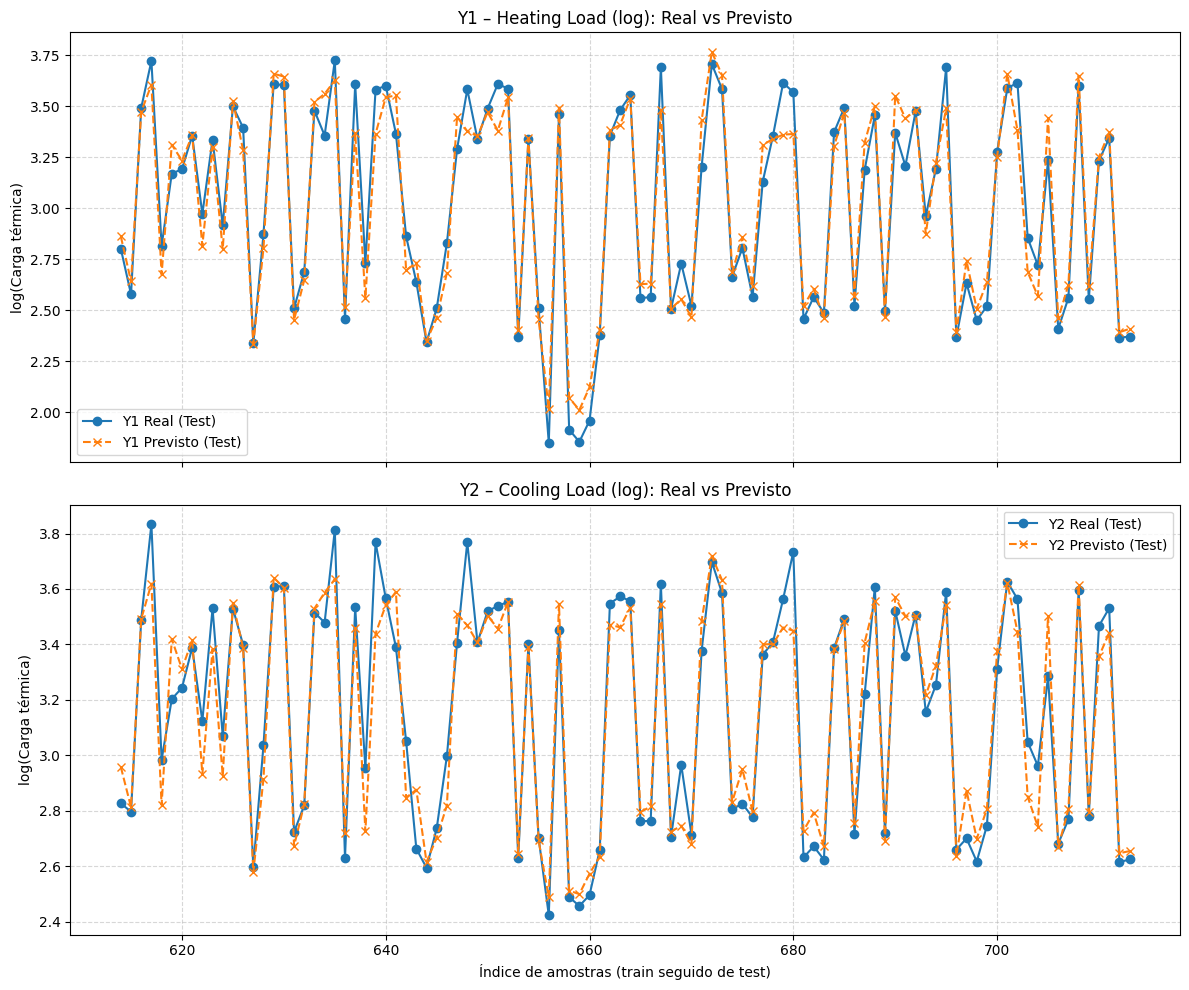

In [87]:
def make_pipeline():
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

# 4) Split treino/teste (mesma divisão para Y1 e Y2)
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X, y1_log, y2_log, test_size=0.2, random_state=42
)

# 5) Ajustar e predizer Y1
pipe_y1 = make_pipeline()
pipe_y1.fit(X_train, y1_train)
y1_train_pred = pipe_y1.predict(X_train)
y1_test_pred  = pipe_y1.predict(X_test)

# 6) Ajustar e predizer Y2
pipe_y2 = make_pipeline()
pipe_y2.fit(X_train, y2_train)
y2_train_pred = pipe_y2.predict(X_train)
y2_test_pred  = pipe_y2.predict(X_test)

# 7) Plot “Real vs Previsto” para Train & Test de Y1 e Y2
n_plot = 100  # quantas amostras mostrar em cada segmento

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Y1 ---
# Índices das amostras de teste para encaixar no eixo X
test_idx = np.arange(len(y1_train), len(y1_train) + n_plot)

axes[0].plot(test_idx, y1_test.values[:n_plot],    label='Y1 Real (Test)',    marker='o', linestyle='-')
axes[0].plot(test_idx, y1_test_pred[:n_plot],      label='Y1 Previsto (Test)', marker='x', linestyle='--')

axes[0].set_title('Y1 – Heating Load (log): Real vs Previsto')
axes[0].set_ylabel('log(Carga térmica)')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# --- Y2 ---
test_idx = np.arange(len(y2_train), len(y2_train) + n_plot)

axes[1].plot(test_idx, y2_test.values[:n_plot],    label='Y2 Real (Test)',    marker='o', linestyle='-')
axes[1].plot(test_idx, y2_test_pred[:n_plot],      label='Y2 Previsto (Test)', marker='x', linestyle='--')

axes[1].set_title('Y2 – Cooling Load (log): Real vs Previsto')
axes[1].set_xlabel('Índice de amostras (train seguido de test)')
axes[1].set_ylabel('log(Carga térmica)')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Avaliação e Comparação de Modelos Baseline para Y1 e Y2

In [62]:
warnings.filterwarnings("ignore")

# Usar KFold em vez de StratifiedKFold para regressão
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Obter todos os regressores
all_regressors = all_estimators(type_filter='regressor')

# Dicionário de hiperparâmetros simples para busca (poderia ser expandido por modelo)
param_grids = {
    'ARDRegression': {'regressor__alpha_1': [1e-6, 1e-3], 'regressor__alpha_2': [1e-6, 1e-3]},
    'AdaBoostRegressor': {'regressor__n_estimators': [50, 100], 'regressor__learning_rate': [0.5, 1.0]},
    'BaggingRegressor': {'regressor__n_estimators': [10, 50], 'regressor__max_samples': [0.5, 1.0]},
    'BayesianRidge': {'regressor__alpha_1': [1e-6, 1e-3], 'regressor__alpha_2': [1e-6, 1e-3]},
    'CCA': {'regressor__n_components': [1, 2]},
    'DecisionTreeRegressor': {'regressor__max_depth': [3, 5, 10]},
    'DummyRegressor': {},  # Sem parâmetros relevantes
    'ElasticNet': {'regressor__alpha': [0.01, 0.1, 1.0], 'regressor__l1_ratio': [0.1, 0.5, 0.9]},
    'ElasticNetCV': {'regressor__l1_ratio': [0.1, 0.5, 0.9]},
    'ExtraTreeRegressor': {'regressor__max_depth': [3, 5, 10]},
    'ExtraTreesRegressor': {'regressor__n_estimators': [50, 100], 'regressor__max_depth': [5, 10]},
    'GammaRegressor': {'regressor__alpha': [0.01, 0.1, 1.0]},
    'GaussianProcessRegressor': {'regressor__alpha': [1e-10, 1e-2]},  # Cuidado: pode ser lento
    'GradientBoostingRegressor': {'regressor__n_estimators': [50, 100], 'regressor__learning_rate': [0.05, 0.1]},
    'HistGradientBoostingRegressor': {'regressor__max_iter': [100, 200], 'regressor__learning_rate': [0.05, 0.1]},
    'HuberRegressor': {'regressor__epsilon': [1.1, 1.35, 1.5]},
    'IsotonicRegression': {},  # Não usa GridSearch diretamente, requer entrada 1D
    'KNeighborsRegressor': {'regressor__n_neighbors': [3, 5, 7]},
    'KernelRidge': {'regressor__alpha': [0.01, 0.1, 1.0], 'regressor__kernel': ['linear', 'rbf']},
    'Lars': {},  # Sem parâmetros principais
    'LarsCV': {},  # Sem parâmetros principais
    'Lasso': {'regressor__alpha': [0.01, 0.1, 1.0]},
    'LassoCV': {'regressor__n_alphas': [50, 100]},
    'LassoLars': {'regressor__alpha': [0.01, 0.1, 1.0]},
    'LassoLarsCV': {},  # Sem parâmetros principais
    'LassoLarsIC': {'regressor__criterion': ['aic', 'bic']},
    'LinearRegression': {},  # Sem hiperparâmetros
    'LinearSVR': {'regressor__C': [0.1, 1.0], 'regressor__epsilon': [0.0, 0.1]},
    'MLPRegressor': {'regressor__hidden_layer_sizes': [(50,), (100,)], 'regressor__alpha': [0.0001, 0.001]},
    'NuSVR': {'regressor__C': [0.5, 1.0], 'regressor__nu': [0.25, 0.5]},
    'OrthogonalMatchingPursuit': {},  # Poucos parâmetros
    'OrthogonalMatchingPursuitCV': {},  # Sem parâmetros principais
    'PLSCanonical': {'regressor__n_components': [1, 2]},
    'PLSRegression': {'regressor__n_components': [1, 2]},
    'PassiveAggressiveRegressor': {'regressor__C': [0.01, 0.1, 1.0]},
    'PoissonRegressor': {'regressor__alpha': [0.01, 0.1, 1.0]},
    'QuantileRegressor': {'regressor__quantile': [0.25, 0.5, 0.75]},
    'RANSACRegressor': {'regressor__min_samples': [0.5, 0.75]},
    'RadiusNeighborsRegressor': {'regressor__radius': [1.0, 2.0]},
    'RandomForestRegressor': {'regressor__n_estimators': [50, 100], 'regressor__max_depth': [5, 10]},
    'Ridge': {'regressor__alpha': [0.01, 0.1, 1.0]},
    'RidgeCV': {'regressor__alphas': [[0.01, 0.1, 1.0]]},
    'SGDRegressor': {'regressor__alpha': [0.0001, 0.001], 'regressor__penalty': ['l2', 'l1']},
    'SVR': {'regressor__C': [0.1, 1.0], 'regressor__kernel': ['linear', 'rbf']},
    'TheilSenRegressor': {},  # Poucos parâmetros úteis para GridSearch
    'TransformedTargetRegressor': {},  # Wrapper, ignora
    'TweedieRegressor': {'regressor__power': [0, 1.5], 'regressor__alpha': [0.01, 0.1]},
}

In [63]:
# Avaliação para Y1
results_y1, best_models_y1, X_test_y1, y_test_y1 = evaluate_regressors(
    X_reduced, data["Y1_heating_load"], kfold, scorer, param_grids, all_regressors
)

# Avaliação para Y2
results_y2, best_models_y2, X_test_y2, y_test_y2 = evaluate_regressors(
    X_reduced, data["Y2_cooling_load"], kfold, scorer, param_grids, all_regressors
)

Erro com IsotonicRegression: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args

Pares com Correlação Forte (|ρ| > 0.95)

- (X1_compactness, X2_surface_area): ρ ≈ –0,99 (correlação negativa quase perfeita)

- (X4_roof_area, X5_height): ρ ≈ –0,97 (correlação negativa muito alta)

Nenhum outro par de variáveis preditoras atinge |ρ| > 0,95. As outras correlações mais altas são X2–X4 (≈+0,88) e X1–X5 (≈+0,83), abaixo do limiar.

Recomendação de Eliminação/Combinação de Variáveis

Os pares identificados mostram multicolinearidade severa entre as variáveis. Manter ambas variáveis altamente correlacionadas não acrescenta informação nova e pode prejudicar modelos lineares. Conforme sugerido na literatura, é usual eliminar uma das variáveis redundantes ou combiná-las (e.g. via PCA) para reduzir dimensões mantendo informação essencial. (MARQUES; MARQUES, 2016).

- No nosso caso:X1 e X2 (compactness vs. surface area): são quase lineares entre si. Podem ser combinadas num único componente ou, mais simples, descartar uma. Por exemplo, manter X1 (compactness) e remover X2, pois a compactação já reflete o efeito da área da superfície

- X4 e X5 (roof area vs. height): também são quase lineares. Sugere-se manter X5 (height) e remover X4, já que a altura captura parte do efeito do volume edificável que o telhado implica

Se houvesse grupos de 3 ou mais variáveis correlacionadas, poder-se-ia usar PCA para combiná-las. Aqui temos apenas pares, então a eliminação simples é suficiente. Deixar ambas (sem tratamento) não é recomendado, pois confundiria o modelo (multicolinearidade) sem ganho de variância explicada

Referência:

MARQUES, J. M.; MARQUES, M. A. M. As componentes principais no descarte de variáveis em um modelo de regressão múltipla. Revista da FAE, [S. l.], v. 8, n. 1, 2016. Disponível em: https://revistafae.fae.edu/revistafae/article/view/378. Acesso em: 3 maio. 2025.

In [64]:
# Para Y1 - Heating Load
results_df_y1, top4_y1 = rank_models(results_y1, nome_target="Y1 - Aquecimento")

# Para Y2 - Cooling Load
results_df_y2, top4_y2 = rank_models(results_y2, nome_target="Y2 - Resfriamento")



Top 4 modelos para Y1 - Aquecimento considerando todas as métricas:
                    Regressor  RMSE Mean       MAE        R²  Avg_rank
10        ExtraTreesRegressor   0.485946  0.323145  0.997636  1.000000
13  GradientBoostingRegressor   0.497438  0.351705  0.997549  2.666667
38      RandomForestRegressor   0.510265  0.339310  0.997400  2.666667
2            BaggingRegressor   0.520258  0.345694  0.997291  3.666667

Top 4 modelos para Y2 - Resfriamento considerando todas as métricas:
                        Regressor  RMSE Mean       MAE        R²  Avg_rank
14  HistGradientBoostingRegressor   1.155961  0.822047  0.985087  1.000000
13      GradientBoostingRegressor   1.535317  1.040685  0.973688  2.333333
38          RandomForestRegressor   1.748561  1.031548  0.966736  3.333333
17                    KernelRidge   1.699302  1.183642  0.967791  3.666667


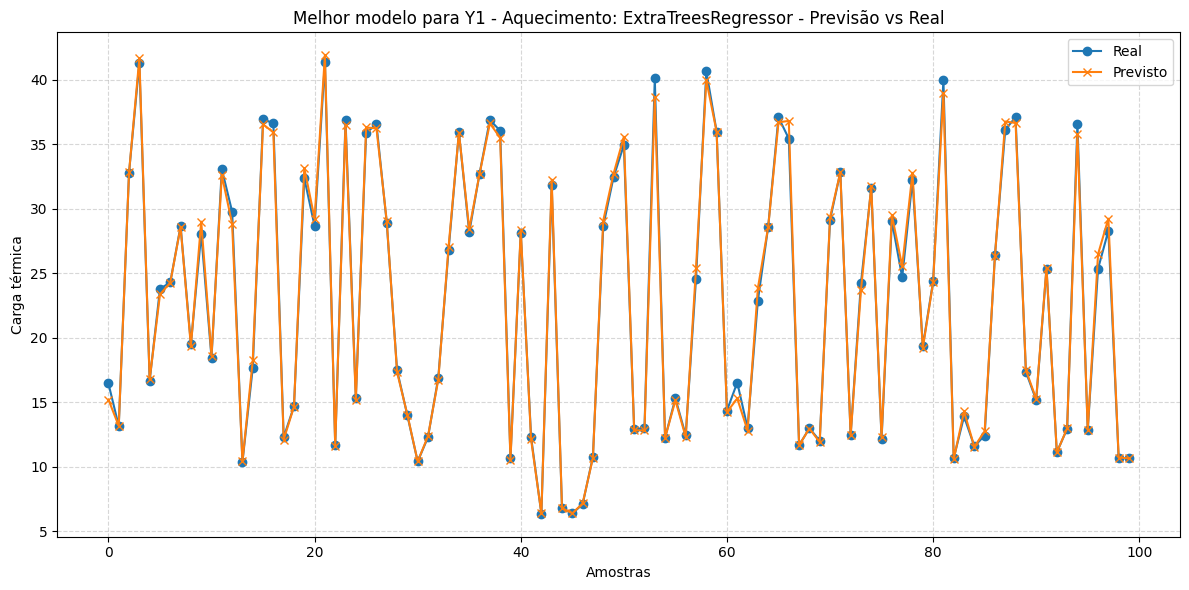

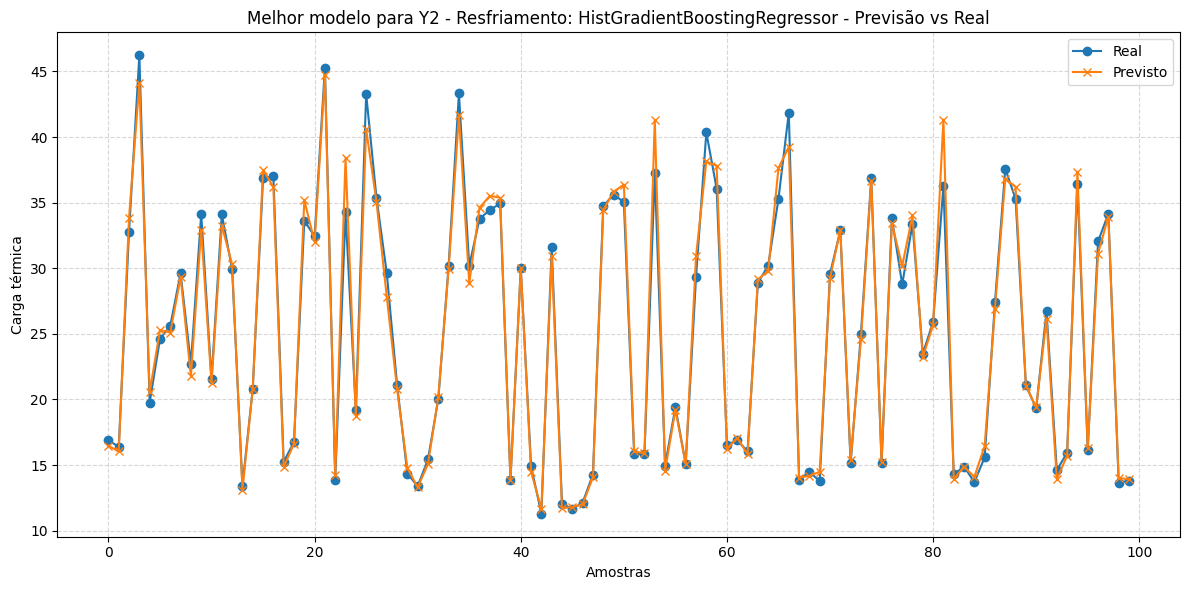

In [65]:
plot_best(results_df_y1, best_models_y1, X_test_y1, y_test_y1, nome_target="Y1 - Aquecimento")
plot_best(results_df_y2, best_models_y2, X_test_y2, y_test_y2, nome_target="Y2 - Resfriamento")